In [1]:
import sys; sys.path.insert(0, '..')
import pandas as pd
import yfinance as yf
import glob
import re
from datetime import datetime
from data.preprocessing import get_price
import os
#from utils.utils_analyze import *
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [30]:
df = get_model_trade_history('a16z-v0-test')
df.tail()

,ticker,amount,price
Date,,,
2006-05-15,CSCO,100.000000,17.916735
2006-05-15,CRM,49.961124,9.755000
2006-05-15,INTC,46.391281,13.872895
2006-05-15,BA,42.212708,57.477348
2006-05-15,ADBE,32.466648,38.250000


# Compare different models

In [2]:
buy_and_hold = get_buy_and_hold('./snp45-2000.csv', start_test, end_test)

NameError: name 'get_buy_and_hold' is not defined

In [10]:
model_one = get_account_value('snp_40_stock_model', rebalance_window, validation_window, unique_trade_date, df_trade_date)
model_two = get_account_value('warren-v0', rebalance_window, validation_window, unique_trade_date, df_trade_date)
buy_and_hold_strategy = backtest_strat(buy_and_hold)

1.1262157796930559
1.1550428677132045


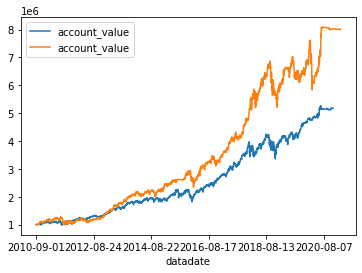

In [11]:
model_one.set_index('datadate').account_value.plot(rot=70)
model_two.set_index('datadate').account_value.plot(rot=70)
plt.legend()

In [71]:
agents = pd.read_csv('../agents_hparams.csv')

In [73]:
agents.tail()

,model_name,model_type,total_reward,start_date,end_date,dataset_version,hparams,net_arch,sharpe,train-start,train-end,indicators,env_hparams
1573,wb-v8,<class 'stable_baselines3.ppo.ppo.PPO'>,-100.0,2009-01-01,2021-11-08 19:41:18.362794,pretrainedTrial6,ent_coef:0.005,NaN,NaN,2009-01-01,2011-07-05 00:00:00,"macd,tema,boll,boll_ub,boll_lb,wr_10,rsi_30,rs...",NaN
1574,wb-v8,<class 'stable_baselines3.ppo.ppo.PPO'>,-100.0,2009-01-01,2021-11-08 19:41:18.362794,pretrainedTrial6,ent_coef:0.005,NaN,NaN,2009-01-01,2011-10-03 00:00:00,"macd,tema,boll,boll_ub,boll_lb,wr_10,rsi_30,rs...",NaN
1575,wb-v8,<class 'stable_baselines3.ppo.ppo.PPO'>,-100.0,2009-01-01,2021-11-08 19:41:18.362794,pretrainedTrial6,ent_coef:0.005,NaN,NaN,2009-01-01,2012-01-03 00:00:00,"macd,tema,boll,boll_ub,boll_lb,wr_10,rsi_30,rs...",NaN
1576,wb-v8,<class 'stable_baselines3.ppo.ppo.PPO'>,-100.0,2009-01-01,2021-11-08 19:41:18.362794,pretrainedTrial6,ent_coef:0.005,NaN,NaN,2009-01-01,2012-04-03 00:00:00,"macd,tema,boll,boll_ub,boll_lb,wr_10,rsi_30,rs...",NaN
1577,wb-v8,<class 'stable_baselines3.ppo.ppo.PPO'>,-100.0,2009-01-01,2021-11-08 19:41:18.362794,pretrainedTrial6,ent_coef:0.005,NaN,NaN,2009-01-01,2012-07-03 00:00:00,"macd,tema,boll,boll_ub,boll_lb,wr_10,rsi_30,rs...",NaN


In [7]:
trade_mem = pd.read_csv('../results/trade_memory_jim_sac-v13.csv')

In [3]:
def plot_stock_holdings(ticker, trade_mem):
    trade_mem.Date = pd.to_datetime(trade_mem.Date).dt.date
    
    start = trade_mem.Date.values[0]
    end = trade_mem.Date.values[-1]

    start = datetime.strptime(str(start), '%Y-%m-%d')
    end = datetime.strptime(str(end), '%Y-%m-%d')

    stock = get_price(ticker, start, end)
 
    traded_stock = trade_mem[trade_mem.ticker == ticker]
    n = calculate_holdings(traded_stock)
    
    ax1 =n.plot(x='Date', y='holdings', alpha=0.9
            , color='r')
    ax2=ax1.twinx()
    ax2.plot(stock['Date'], stock['Adj Close'],color="blue",marker="o")
    ax2.set_ylabel("Price",color="blue",fontsize=14)
    #ax2.xticks(rotation=45)
    
    plt.title(ticker)
    plt.show()
    return ax2

In [8]:
plot_stock_holdings('AAPL',trade_mem)

[*********************100%***********************]  1 of 1 completed


NameError: name 'calculate_holdings' is not defined

In [5]:
def display_buy_sell(ticker, trade_mem):
    trade_mem.Date = pd.to_datetime(trade_mem.Date).dt.date
    
    start = trade_mem.Date.values[0]
    end = trade_mem.Date.values[-1]

    start = datetime.strptime(str(start), '%Y-%m-%d')
    end = datetime.strptime(str(end), '%Y-%m-%d')
    
    stock = get_price(ticker, start, end)
    print('Stock prices set')
    stock = stock.set_index('Date')
    stock_trades = trade_mem[trade_mem.ticker == ticker]
    stock_trades['action'] = stock_trades.amount.apply(lambda x: -1 if x < 0 else 0 if x == 0 else 1)
    sells = stock_trades[stock_trades.action < 0]
    
    buys = stock_trades[stock_trades.action > 0]

    #ax = fig.add_subplot(111)
    #plotting
    #plt.style.use('fivethirtyeight')
   
    ax1 =sells.plot(kind='scatter', x='Date', y='price', alpha=0.6
            ,marker='o', color='r')
    ax2 = buys.plot(kind='scatter', x='Date', y='price',alpha=0.6,
                marker='o', color='b', ax = ax1)
    fig = stock['Adj Close'].plot(rot=70, alpha = 0.7, color='grey', figsize=(12,12))
    plt.xticks( rotation='vertical')
    ax2.set_xticks(ax2.get_xticks()[::2])
    #plt.savefig('pos_neg.png', dpi=200)
    plt.title(ticker)
    #plt.show()
    return fig
    

[*********************100%***********************]  1 of 1 completed
Stock prices set


C:\Users\kaanb\Anaconda3\envs\pytorchgpu\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


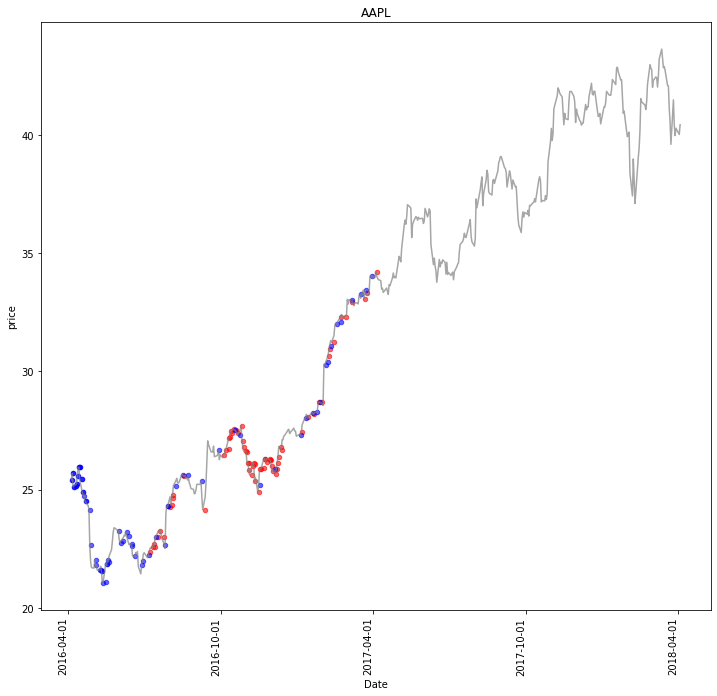

In [10]:
f = display_buy_sell('AAPL', trade_mem)

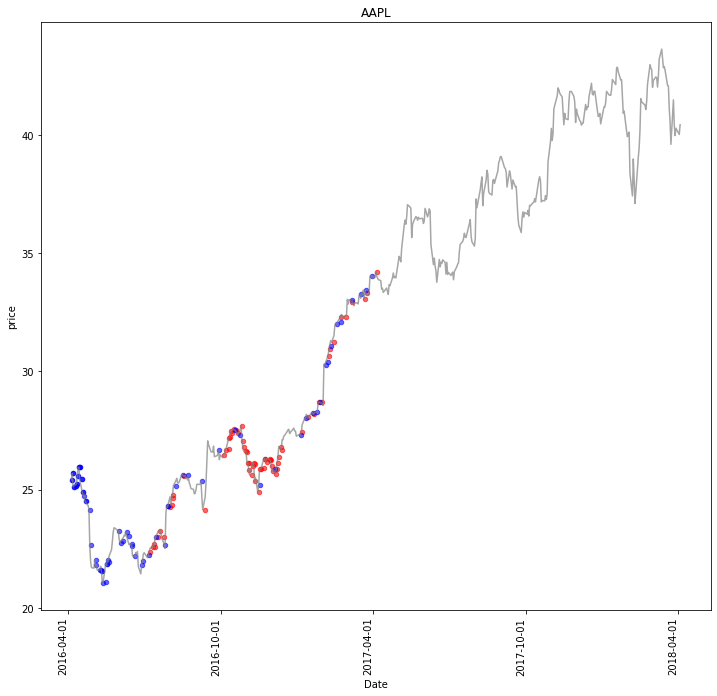

In [13]:
f.figure 

In [214]:
trade_mem.ticker.unique()

array(['XOM', 'WMT', 'AXP', 'BA', 'CAT', 'CVX', 'DD', 'DIS', 'GS', 'HD',
       'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MMM', 'MRK', 'NKE', 'PFE',
       'PG', 'RTX', 'TRV', 'UNH', 'VZ', 'WBA', 'AAPL', 'MCD', 'MSFT', 'V',
       'CSCO'], dtype=object)

In [101]:
start = trade_mem.Date.values[0]
end = trade_mem.Date.values[-1]
stock = get_price('BA', start, end)

stock = stock.set_index('Date')
stock_trades = trade_mem[trade_mem.ticker == 'BA']
stock['Adj Close'].plot(rot=70)

Exception in thread Thread-17:
Traceback (most recent call last):
  File "C:\Users\kaanb\Anaconda3\envs\pytorchgpu\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\kaanb\Anaconda3\envs\pytorchgpu\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\kaanb\Anaconda3\envs\pytorchgpu\lib\site-packages\multitasking\__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)
  File "C:\Users\kaanb\Anaconda3\envs\pytorchgpu\lib\site-packages\yfinance\multi.py", line 170, in _download_one_threaded
    actions, period, interval, prepost, proxy, rounding)
  File "C:\Users\kaanb\Anaconda3\envs\pytorchgpu\lib\site-packages\yfinance\multi.py", line 185, in _download_one
    rounding=rounding, many=True)
  File "C:\Users\kaanb\Anaconda3\envs\pytorchgpu\lib\site-packages\yfinance\base.py", line 146, in history
    end = int(_time.mktime(_time.strptime(str(end), '%Y-%m-%d')))
  File "C:\Users\kaanb\Anaconda3\

KeyboardInterrupt: 

In [74]:
ba = calculate_holdings(stock_trades)

In [75]:
ba

,Date,ticker,amount,price,action,holdings
0,2009-10-02,BA,100.0,39.703064,0,0
1,2009-10-05,BA,100.0,40.382790,100,0
2,2009-10-06,BA,100.0,40.390526,200,0
3,2009-10-07,BA,100.0,40.004322,300,0
4,2009-10-08,BA,100.0,40.398251,400,0
...,...,...,...,...,...,...
224,2010-11-16 00:00:00,BA,-100.0,50.143177,100,0
225,2010-11-26 00:00:00,BA,100.0,51.756588,0,0
226,2010-11-29 00:00:00,BA,-100.0,51.405144,100,0
227,2010-12-16 00:00:00,BA,100.0,51.437099,0,0


C:\Users\kaanb\Anaconda3\envs\pytorchgpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='Date'>

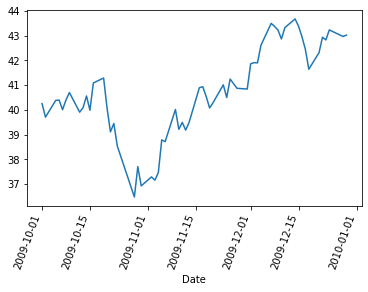

In [33]:
stock_trades = trade_mem[trade_mem.ticker == 'BA']
stock_trades['action'] = stock_trades.amount.apply(lambda x: -1 if x < 0 else 0 if x == 0 else 1)
stock['Adj Close'].plot(rot=70)

In [85]:
stock_trades.Date = pd.to_datetime(stock_trades.Date)

C:\Users\kaanb\Anaconda3\envs\pytorchgpu\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


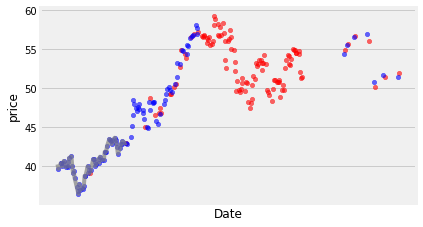

In [154]:

sells = stock_trades[stock_trades.action <= 0]
buys = stock_trades[stock_trades.action > 0]

ax = fig.add_subplot(111)
#plotting
#plt.style.use('fivethirtyeight')

ax1 =sells.plot(kind='scatter', x='Date', y='price', alpha=0.6
            ,marker='o', color='r')
ax2 = buys.plot(kind='scatter', x='Date', y='price',alpha=0.6,
            marker='o', color='b', ax = ax1)
stock['Adj Close'].plot(rot=70, alpha = 0.7, color='grey')
plt.xticks( rotation='vertical')
ax2.set_xticks(ax.get_xticks()[::12])
#plt.savefig('pos_neg.png', dpi=200)
plt.show()


In [84]:
sells

,Date,ticker,amount,price,action
314,2009-11-12,BA,-100.0,39.180042,-1
640,2009-12-29,BA,-100.0,43.021694,-1
848,2010-01-22 00:00:00,BA,0.0,45.016537,0
904,2010-01-28 00:00:00,BA,0.0,48.749077,0
973,2010-02-04 00:00:00,BA,0.0,46.539932,0
...,...,...,...,...,...
3387,2010-10-21 00:00:00,BA,-100.0,56.764229,-1
3593,2010-11-08 00:00:00,BA,-100.0,56.077614,-1
3694,2010-11-16 00:00:00,BA,-100.0,50.143177,-1
3831,2010-11-29 00:00:00,BA,-100.0,51.405144,-1


In [83]:
buys

,Date,ticker,amount,price,action
2,2009-10-02,BA,100.0,39.703064,1
14,2009-10-05,BA,100.0,40.382790,1
24,2009-10-06,BA,100.0,40.390526,1
36,2009-10-07,BA,100.0,40.004322,1
45,2009-10-08,BA,100.0,40.398251,1
...,...,...,...,...,...
3378,2010-10-20 00:00:00,BA,100.0,56.653069,1
3580,2010-11-05 00:00:00,BA,100.0,56.924255,1
3682,2010-11-15 00:00:00,BA,100.0,50.806118,1
3824,2010-11-26 00:00:00,BA,100.0,51.756588,1


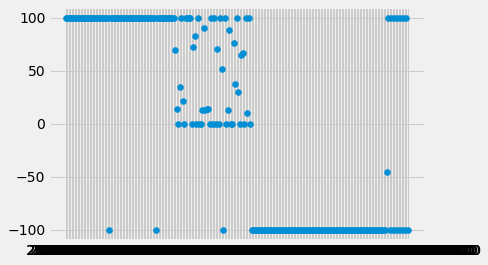

In [50]:
plt.scatter(stock_trades.Date.values,stock_trades.amount.values)

In [51]:
stock_trades

,Date,ticker,amount,price,action
2,2009-10-02,BA,100.0,39.703064,1
14,2009-10-05,BA,100.0,40.382790,1
24,2009-10-06,BA,100.0,40.390526,1
36,2009-10-07,BA,100.0,40.004322,1
45,2009-10-08,BA,100.0,40.398251,1
...,...,...,...,...,...
3694,2010-11-16 00:00:00,BA,-100.0,50.143177,-1
3824,2010-11-26 00:00:00,BA,100.0,51.756588,1
3831,2010-11-29 00:00:00,BA,-100.0,51.405144,-1
4029,2010-12-16 00:00:00,BA,100.0,51.437099,1
